In [21]:
from PIL import Image

import pandas as pd
import requests
import torch
import whisper
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

In [2]:
model_name = "small"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
audio_file = "/home/tuts/repos/tutss/datascience/notebooks/audio-jeans.mp3"

In [4]:
db = {
    "blusa": [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSd8s6klk83uiiGi96lTl7_nnoxeoR7cFxCioJn_NIVrcsQ5epL-tiUlM6shrz8-qrhEZ4&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMCKD2g8TYTv5RAk_Ck47gSnCjYVZGGMZMbvAtS0J396-Pxo1AtZa3ITXG8AlY2k7Cu8o&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdx9ja1BmqLSuerAPscyvqL5tNOidDS6bdmQale3km2U27hR_v6ldOW7smuetNYM2_NjE&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTamaPf4zfc7t-F7HyTK25JCf-B-hFXaWLpsmmIbQhXftmGXYFE6wnOiVYAyx5rNJuWzVo&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6iZ70MSJGwBtwHnOkXJwKoyUm8OSi5-C7cDt2KtjLwe8UtvSPrvrJpeTPeR9IT4kA0r0&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRISkK44iAvXfM2Lf3GjuVcGjqJWuU3ghITPk-j1SoOkLzSZKiyFKIB9aZIIY_d0nNrr6c&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvl9iCMkNRk67ooAA8g35gAXr0mpnhG_IFWJw1o20dh4kmt3wK_j9GSkIHaQs75NKmgLg&usqp=CAU"
    ],
    "calca": [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSNclrZobuYRy-N2wr6t0z5aZdvHVUHIfNGGw&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTLZVDFtiby3Qw-6w5f-WA9e1QAQ0wHR-54R1LgxQwhB3gcQaZa2HwWC5tDxK2C3fPKVu8&usqp=CAU",
        "https://cdn.awsli.com.br/600x700/809/809422/produto/39732279/b34e774923.jpg",
        "https://cdn.awsli.com.br/600x1000/622/622351/produto/54302663/1-57mg2y5pku.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9fe_sXHursYxzKlO5-COHAdrb8whUvotIMndTUgGlJlHAUmkEjjU5qM-_poLo00EVCzk&usqp=CAU",
        "https://images.tcdn.com.br/img/img_prod/952230/calca_masculina_alfaiataria_sarja_slim_marrom_2677_1_07c600b012552131b3eac41440927779.jpg",
    ],
    "tenis": [
        "https://assets.adidas.com/images/w_600,f_auto,q_auto/32c151dc88224a6f93b1af1200ec5a6a_9366/Tenis_Response_Runner_Preto_ID7336_01_standard.jpg",
        "https://imgcentauro-a.akamaihd.net/1366x1366/97360651A1.jpg",
        "https://m.media-amazon.com/images/I/41NzGgXXNtL._AC_.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSJunUHQYimjlopx3ZaphqM_W9M-d-OI9nqGg&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdT9fg9YvaGBUaFofBNka8HjpTrpuYUAmgRg&usqp=CAU"
    ]
}

data = pd.DataFrame(columns=["tipo", "url", "img_embeddings"])

In [5]:
model = whisper.load_model(model_name)

In [6]:
result = model.transcribe(audio_file)
print(result["text"])

 Eu quero uma calça jeans.


In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model     = model.to(device)

/home/tuts/anaconda3/envs/transformer-env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
def compute_text_embeddings(list_of_strings):
    inputs = processor(text=list_of_strings, return_tensors="pt", padding=True).to(device)
    return model.get_text_features(**inputs)

def compute_image_embeddings(image):
    inputs = processor(images=image, return_tensors="pt")["pixel_values"].to(device)
    return model.get_image_features(inputs)

In [9]:
for roupa in db:
    roupas = db[roupa]
    print(f"Processando {roupa}...")
    for url in roupas:
        image = Image.open(requests.get(url, stream=True).raw)
        roupa_emb = pd.Series(compute_image_embeddings(image).cpu().detach().numpy().squeeze())
        row = pd.DataFrame({"tipo": roupa, "url": url, "img_embeddings": [roupa_emb.values]})
        data = pd.concat([row, data], ignore_index=True)

data

Processando blusa...
Processando calca...
Processando tenis...


,tipo,url,img_embeddings
0,tenis,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[-0.13344294, -0.0071667433, 0.3651489, -0.007..."
1,tenis,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[-0.042119086, -0.13528009, 0.38588357, 0.1197..."
2,tenis,https://m.media-amazon.com/images/I/41NzGgXXNt...,"[-0.32635742, -0.26123184, 0.056026153, 0.0856..."
3,tenis,https://imgcentauro-a.akamaihd.net/1366x1366/9...,"[-0.3002138, -0.11452687, 0.14590412, -0.16849..."
4,tenis,"https://assets.adidas.com/images/w_600,f_auto,...","[-0.12737457, -0.31129998, -0.062180296, -0.08..."
5,calca,https://images.tcdn.com.br/img/img_prod/952230...,"[-0.19851458, -0.041692257, 0.22888346, -0.006..."
6,calca,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[0.22138892, 0.073809445, 0.28953156, 0.583352..."
7,calca,https://cdn.awsli.com.br/600x1000/622/622351/p...,"[-0.4273479, -0.0070836544, 0.25028476, 0.1503..."
8,calca,https://cdn.awsli.com.br/600x700/809/809422/pr...,"[-0.114882715, 0.0048525333, 0.34585655, -0.09..."
9,calca,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[0.49320704, -0.008565813, 0.12895262, 0.23290..."


In [ ]:
data.to_csv('database-products.csv', index=False)

https://cdn.awsli.com.br/600x1000/622/622351/produto/54302663/1-57mg2y5pku.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9fe_sXHursYxzKlO5-COHAdrb8whUvotIMndTUgGlJlHAUmkEjjU5qM-_poLo00EVCzk&usqp=CAU https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTLZVDFtiby3Qw-6w5f-WA9e1QAQ0wHR-54R1LgxQwhB3gcQaZa2HwWC5tDxK2C3fPKVu8&usqp=CAU


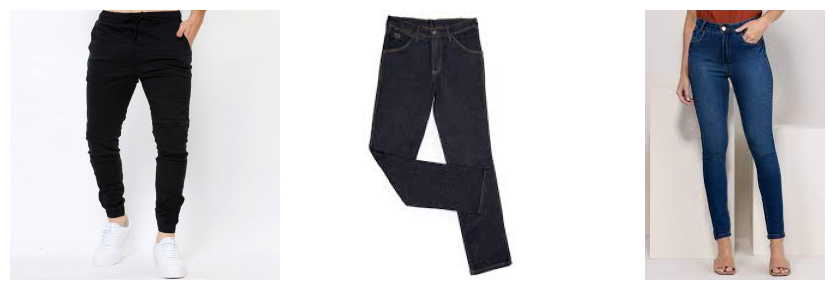

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_top_N_images(query, top_K=3):
    query_vect = compute_text_embeddings([query]).cpu().detach().numpy()
    
    # Run similarity Search
    similarities = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, [x]))
    # print(similarities)
    sorted_similarities = similarities.sort_values(ascending=False)
    # print(sorted_similarities.index[:3])
    idx = np.argmax(similarities)

    return data.iloc[sorted_similarities.index[:top_K]]

most_similar = get_top_N_images(result["text"])
# print(most_similar)

fig, axs = plt.subplots(1, 3, figsize=(9,3))
print(' '.join(most_similar['url']))
for item, ax in zip(most_similar["url"], axs):
    image = Image.open(requests.get(item, stream=True).raw)
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()
